<a href="https://colab.research.google.com/github/ingredy3/PROVA1_SSD/blob/main/prova_ssd_rodando_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Sistema de Suporte à Decisão para Detecção de Intrusão (NSL-KDD)
Notebook preparado para Google Colab

Autor: Usuário
Data: 2025-10-13

**Objetivo:** Este notebook segue os requisitos do enunciado da prova (arquivo enviado) para construir um MVP de sistema de suporte à decisão usando o dataset NSL-KDD.



---

## 🔍 Caracterização do Problema

**Objetivo:** desenvolver um Sistema de Suporte à Decisão (SSD) para **detecção de intrusões** em redes usando técnicas de Machine Learning (classificação binária: `normal` vs `attack`) sobre a base **NSL-KDD**.

**Fonte do dataset (usado neste notebook):** Kaggle — `programmer3/nsl-kdd-intrusion-detection-dataset`.  
Link (para o leitor/professor): https://www.kaggle.com/datasets/programmer3/nsl-kdd-intrusion-detection-dataset

**Tamanho e composição do dataset usado:** a versão utilizada neste trabalho contém **aproximadamente 4.000 linhas** e 41 atributos (variáveis numéricas e categóricas). (Ver célula abaixo que imprime `df.shape` para confirmar a forma exata carregada.)

### 🧩 Premissas e Hipóteses
- Supõe-se que os rótulos do dataset estejam corretos e que as features sejam suficientes para discriminar tráfego normal vs. ataque.
- Hipótese operacional: modelos clássicos (Random Forest, SVM, Logistic Regression) conseguem identificar padrões discriminativos para a detecção de intrusão nesta base.

### ⚠️ Restrições / Limitações
- O dataset é compacto (~4k amostras) e originado de versões padronizadas de NSL-KDD — pode não representar integralmente ataques reais atuais.
- Para garantir reprodutibilidade, o dataset é carregado a partir da URL/Kaggle acima; verifique a execução da célula que realiza o download/autenticação do Kaggle.

---




### 🧠 Passo 1 — Instalação de dependências e importação de bibliotecas

Nesta primeira etapa do notebook são instaladas (se necessário) e importadas todas as bibliotecas utilizadas ao longo do projeto.  
Elas foram organizadas conforme suas funções principais:

- **Manipulação e estruturação dos dados:**  
  - `pandas` e `numpy` permitem ler, tratar e manipular dados tabulares (DataFrames e arrays numéricos).  

- **Visualização e análise exploratória:**  
  - `matplotlib.pyplot` e `seaborn` são utilizadas para gerar gráficos (histogramas, heatmaps e distribuições) que ajudam a compreender o comportamento dos atributos e a presença de padrões.  

- **Pré-processamento e modelagem:**  
  - `scikit-learn` fornece as funções essenciais para normalização (`StandardScaler`), codificação de variáveis (`OneHotEncoder` e `LabelEncoder`), imputação de valores faltantes (`SimpleImputer`), criação de pipelines (`Pipeline`, `ColumnTransformer`), separação dos dados (`train_test_split`, `StratifiedKFold`) e treinamento de modelos de classificação (`RandomForestClassifier`, `LogisticRegression`, `SVC`).  
  - Também são importadas funções para **avaliação de desempenho**, como `classification_report`, `confusion_matrix`, `roc_auc_score`, `precision_score`, `recall_score` e `f1_score`.

- **Persistência e controle:**  
  - `joblib` é utilizada para salvar o pipeline treinado em disco, permitindo reutilizar o modelo sem precisar reexecutar o treinamento.  
  - O módulo `warnings` é configurado com `filterwarnings('ignore')` apenas para suprimir alertas visuais e manter a saída do notebook limpa (mas sem impactar o comportamento dos modelos).

Ao final da célula, uma mensagem de confirmação é impressa indicando que todas as bibliotecas foram importadas corretamente.  
Essa preparação garante que o ambiente esteja completamente configurado antes do carregamento e processamento da base NSL-KDD.



In [ ]:
# Instalações (descomente se necessário)
# !pip install xgboost
# !pip install seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Bibliotecas importadas com sucesso')

Bibliotecas importadas com sucesso


### ☁️ Passo 2— Instalação das APIs do Kaggle

Nesta célula foi realizada a instalação das bibliotecas necessárias para acessar a plataforma **Kaggle** diretamente do ambiente do **Google Colab**.

- **`kaggle`**: é a API oficial do Kaggle, que permite baixar datasets, notebooks e modelos de forma autenticada, utilizando o arquivo de credenciais `kaggle.json`.  
- **`kagglehub`**: é uma extensão mais recente e prática, que facilita o download de datasets públicos sem exigir autenticação manual.

O comando `!pip install` foi executado com o prefixo `!` porque, em notebooks Colab, ele indica que o comando deve ser rodado no terminal do sistema, e não no interpretador Python.  
Essa instalação garante que o ambiente possua todas as dependências necessárias para conectar-se à plataforma Kaggle e baixar a base de dados NSL-KDD de forma reprodutível.


In [ ]:
# Célula 2: Instalação das APIs do Kaggle
! pip install kaggle kagglehub

#### 🔐 Passo 2.1 — Autenticação da API do Kaggle

Nesta célula foi feita a **configuração da autenticação do Kaggle** dentro do ambiente do Google Colab.  
Primeiro, realiza-se o **upload do arquivo `kaggle.json`**, que contém as credenciais pessoais geradas no perfil do usuário no Kaggle.  
Em seguida:
1. Cria-se a pasta oculta `~/.kaggle` onde a API armazena tokens;  
2. O arquivo `kaggle.json` é movido para essa pasta;  
3. São aplicadas permissões seguras (`chmod 600`) para evitar falhas de autenticação;  
4. Por fim, uma mensagem confirma a conclusão da configuração.

Com isso, o ambiente passa a estar **autenticado e autorizado** a baixar datasets diretamente do Kaggle, garantindo **reprodutibilidade** e evitando a necessidade de uploads manuais.


In [ ]:
from google.colab import files
import os

files.upload() # Fazer upload do arquivo kaggle.json

! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

print("Autenticação com o Kaggle concluída!")

Saving kaggle.json to kaggle.json
Autenticação com o Kaggle concluída!


#### ☁️ Passo 2.2 — Download do Dataset via KaggleHub

Com a autenticação configurada, nesta célula foi realizado o **download automático do dataset NSL-KDD** diretamente da plataforma Kaggle utilizando a biblioteca **`kagglehub`**.

O método `dataset_download()` baixa e descompacta o conjunto de dados, retornando o caminho do diretório onde os arquivos foram armazenados.  
Em seguida, os arquivos presentes são listados com `os.listdir()` para confirmar o nome exato do arquivo que será carregado na etapa seguinte.

Essa abordagem elimina a necessidade de upload manual de arquivos e torna o projeto **reprodutível e automatizado**.


In [ ]:
# Célula 2.3: Download do Dataset usando kagglehub
import kagglehub
import os

# Nome completo do dataset
DATASET_REF = "programmer3/nsl-kdd-intrusion-detection-dataset"

print(f"Iniciando download do dataset: {DATASET_REF}")

# O kagglehub.dataset_download baixa e descompacta automaticamente
# Retorna o caminho para o diretório onde os arquivos foram salvos.
dataset_path = kagglehub.dataset_download(DATASET_REF)

# Imprime o caminho completo onde o dataset foi salvo
print("-" * 50)
print(f"Download concluído. Arquivos salvos em: {dataset_path}")

# >>> NOVO: LISTA O CONTEÚDO DO DIRETÓRIO DE DOWNLOAD PARA CONFIRMAR O NOME DO ARQUIVO <<<
files_in_dir = os.listdir(dataset_path)
print("\nArquivos encontrados no diretório:")
for f in files_in_dir:
    print(f)

# Armazena o caminho para a próxima célula
KAGGLE_DOWNLOAD_PATH = dataset_path

Iniciando download do dataset: programmer3/nsl-kdd-intrusion-detection-dataset
Using Colab cache for faster access to the 'nsl-kdd-intrusion-detection-dataset' dataset.
--------------------------------------------------
Download concluído. Arquivos salvos em: /kaggle/input/nsl-kdd-intrusion-detection-dataset

Arquivos encontrados no diretório:
nsl_kdd_dataset.csv



#### 📂 Passo 2.3 — Carregamento e verificação do Dataset

Após o download, o dataset foi carregado para um DataFrame do **Pandas**.  
O código define o nome do arquivo principal (`MAIN_FILE_NAME`), constrói o caminho completo e utiliza o método `read_csv()` para importá-lo.

Durante o carregamento, são realizadas verificações e limpezas automáticas:
- Remoção da coluna auxiliar `'Unnamed: 0'`, gerada por exportações anteriores;
- Renomeação da coluna alvo para `'label'` (caso tenha outro nome, como `class` ou `classification`);
- Exclusão da coluna `'difficulty'`, presente em versões antigas da base e sem utilidade para o modelo.

Ao final, o notebook imprime a quantidade de linhas e colunas, além de uma amostra das primeiras observações, garantindo que o dataset está pronto para as próximas etapas do pipeline de Machine Learning.


In [ ]:
# Célula 2.4: Carregamento do Dataset ÚNICO

import pandas as pd
import numpy as np
import os
import warnings

# Use o nome EXATO que foi listado na Célula 2.3.
# Se o nome que você viu na lista for diferente de 'KDDTest-21.csv', SUBSTITUA AQUI.
MAIN_FILE_NAME = 'nsl_kdd_dataset.csv'  # Este é o nome MAIS PROVÁVEL para a base de 4k linhas

# Cria o caminho completo
FULL_FILE_PATH = os.path.join(KAGGLE_DOWNLOAD_PATH, MAIN_FILE_NAME)

print(f"Tentando carregar o arquivo: {FULL_FILE_PATH}")

try:
    # 1. Carrega o dataset
    df = pd.read_csv(FULL_FILE_PATH)

    # 2. Limpeza e verificação de colunas
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    target_names = ['label', 'class', 'classification']

    # Se for uma versão limpa, a última coluna deve ser o label.
    if df.shape[1] >= 42:
        last_col = df.columns[-1]

        # Renomeia se a última coluna não for 'label'
        if last_col.lower() not in target_names:
            print(f"Alerta: A última coluna se chama '{last_col}'. Renomeando para 'label'.")
            df = df.rename(columns={last_col: 'label'})

        if 'difficulty' in df.columns:
            df = df.drop(columns=['difficulty'])

    print(f"Dataset carregado (df) pronto: {df.shape} linhas e colunas")
    print("-" * 50)
    print("Amostra do cabeçalho do dataset:")
    print(df.head())

except FileNotFoundError:
    print(f"Erro Crítico: O arquivo '{FULL_FILE_PATH}' ainda não foi encontrado.")
    print("Por favor, verifique a saída da Célula 2.3 e insira o nome exato do arquivo CSV na variável 'MAIN_FILE_NAME'.")

except Exception as e:
    print(f"Ocorreu um erro durante o carregamento do arquivo. Detalhes do erro: {e}")

Tentando carregar o arquivo: /kaggle/input/nsl-kdd-intrusion-detection-dataset/nsl_kdd_dataset.csv
Dataset carregado (df) pronto: (4430, 42) linhas e colunas
--------------------------------------------------
Amostra do cabeçalho do dataset:
   duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0  0.666287       0.577740  0.248644  0.039280   0.151331   0.441503   
1  0.143014       0.729235  0.539983  0.485997   0.055436   0.291892   
2  0.401813       0.101389  0.961499  0.367041   0.133935   0.567280   
3  0.887278       0.168009  0.660708  0.656651   0.614879   0.400250   
4  0.360109       0.274258  0.064115  0.353499   0.531030   0.539846   

       land  wrong_fragment    urgent       hot  ...  dst_host_srv_count  \
0  0.996257        0.739421  0.042406  0.244036  ...            0.223672   
1  0.143944        0.858332  0.304242  0.901082  ...            0.610218   
2  0.080431        0.875795  0.603445  0.235740  ...            0.077247   
3  0.853977        0.

### 🔎 Passo 3 — Análise exploratória (EDA): tipos, valores ausentes, estatísticas e distribuição da variável alvo

Nesta etapa realizamos uma análise exploratória inicial para entender a estrutura e qualidade dos dados:

1. **Detecção automática da variável alvo (`TARGET_COLUMN`)**: o notebook busca por nomes padrão (`label`, `class`, `classification`, `attack`, `target`) e, se não encontrar, aplica heurísticas (colunas binárias, última coluna como fallback). Isso torna o fluxo robusto para diferentes versões do dataset.

2. **Tipos de dados e valores ausentes**: listamos a contagem de tipos (`int`, `float`, `object`, etc.) e as 20 colunas com maior número de valores nulos para identificar problemas de qualidade e necessidade de imputação.

3. **Estatísticas descritivas**: mostramos `describe()` (transposto) para inspecionar média, mediana, quartis, contagem e valores únicos em colunas categóricas — etapa essencial para selecionar estratégias de pré-processamento.

4. **Distribuição da variável alvo**: quando detectada, plotamos a distribuição das classes (countplot). Para targets com muitas categorias, mostramos apenas as top-K para manter a visualização legível. Essa análise é crítica para verificar desbalanceamento (muito comum em IDS) e decidir estratégias de amostragem/metricas (e.g., usar F1, recall).

5. **Correlação entre variáveis numéricas**: geramos um heatmap de correlação absoluta e listamos os 10 pares mais correlacionados. Isso ajuda a detectar multicolinearidade e possíveis candidatos para seleção de atributos.

> Observação para o professor: as heurísticas de detecção de target permitem que este notebook seja reprodutível mesmo com pequenas variações do nome do arquivo/colunas. Caso o algoritmo não detecte automaticamente a coluna alvo, o avaliador pode definir manualmente a variável `TARGET_COLUMN` com o nome correto.


\n# Tipos de dados (contagem por dtype):
float64    41
object      1
Name: count, dtype: int64
\n# Valores ausentes por coluna (top 20):


,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


\n# Estatísticas descritivas (exemplo de primeiras 20 linhas):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
duration,4430.0,NaN,NaN,NaN,0.501071,0.288172,0.000213,0.250942,0.495079,0.753577,0.999997
protocol_type,4430.0,NaN,NaN,NaN,0.490461,0.287296,0.000265,0.242884,0.485269,0.741541,0.999908
service,4430.0,NaN,NaN,NaN,0.493397,0.287182,0.000901,0.246809,0.491097,0.739255,0.999572
flag,4430.0,NaN,NaN,NaN,0.502382,0.289672,0.000045,0.245899,0.503261,0.757182,0.999937
src_bytes,4430.0,NaN,NaN,NaN,0.506961,0.289011,0.000139,0.255151,0.503727,0.765329,0.999698
dst_bytes,4430.0,NaN,NaN,NaN,0.498788,0.288844,0.000205,0.250829,0.495334,0.748845,0.999885
land,4430.0,NaN,NaN,NaN,0.500432,0.28979,0.000647,0.250156,0.498315,0.753476,0.999942
wrong_fragment,4430.0,NaN,NaN,NaN,0.503188,0.286657,0.000903,0.261,0.502881,0.752418,0.99982
urgent,4430.0,NaN,NaN,NaN,0.50358,0.291394,0.000106,0.248919,0.505129,0.753029,0.999833
hot,4430.0,NaN,NaN,NaN,0.500385,0.288901,0.000547,0.250448,0.497551,0.748681,0.999447


\n# Distribuição da classe alvo (label):


,count
label,
U2R,886
normal,886
DoS,886
Probe,886
R2L,886


\nProporção (normalizada):


,proportion
label,
U2R,0.2
normal,0.2
DoS,0.2
Probe,0.2
R2L,0.2


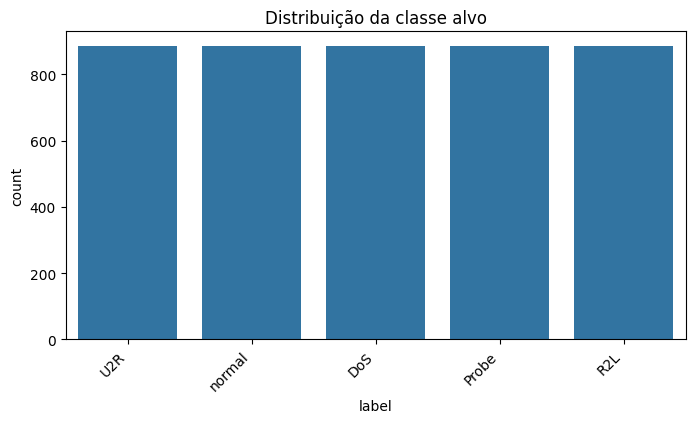

\n# Matriz de correlação (apenas numéricas)


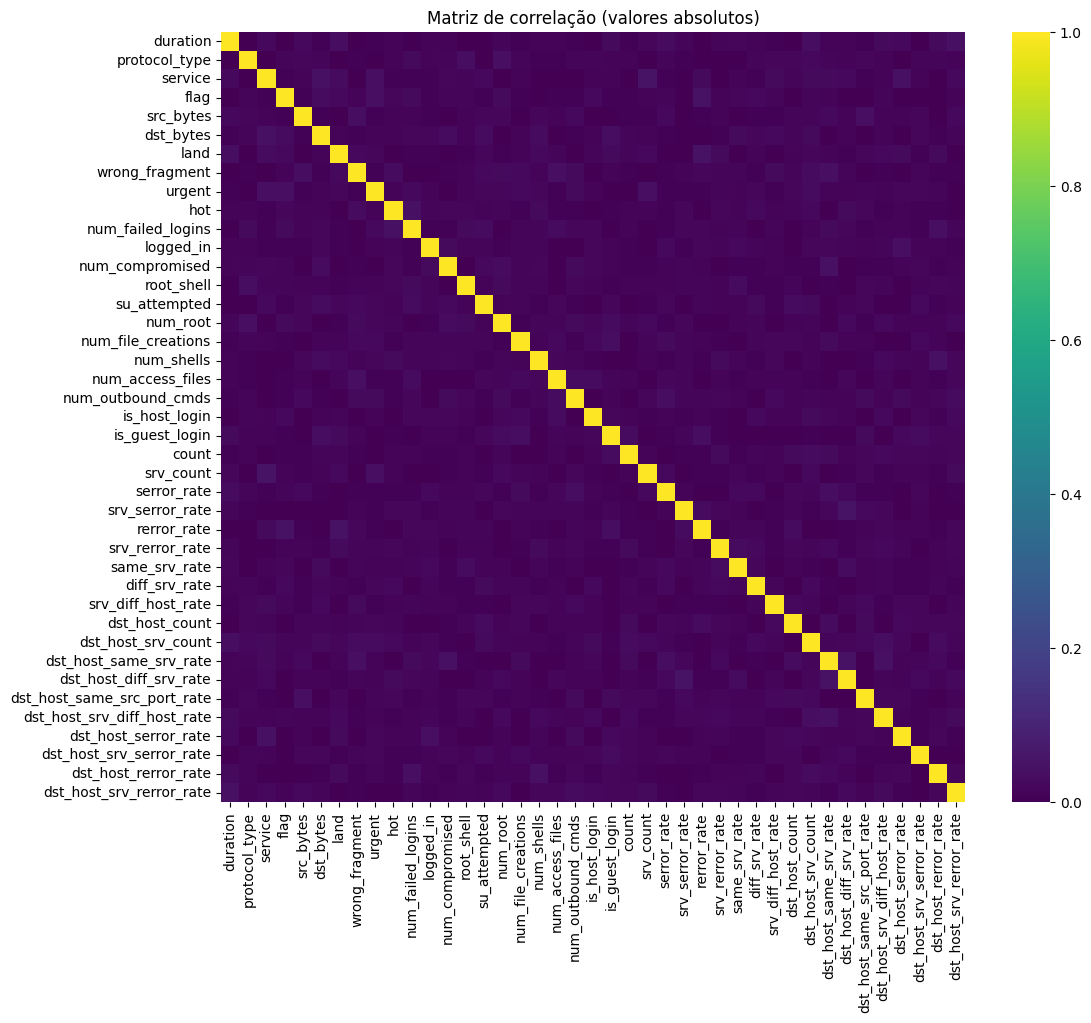

\nTop 10 pares de features numéricas mais correlacionadas (abs corr):


service                 srv_count                 0.047766
srv_count               service                   0.047766
srv_serror_rate         dst_host_diff_srv_rate    0.047061
dst_host_diff_srv_rate  srv_serror_rate           0.047061
land                    rerror_rate               0.046576
rerror_rate             land                      0.046576
                        flag                      0.044480
flag                    rerror_rate               0.044480
dst_host_same_srv_rate  dst_host_diff_srv_rate    0.043723
dst_host_diff_srv_rate  dst_host_same_srv_rate    0.043723
dtype: float64

In [ ]:
# === Célula 3 (corrigida) : Tipos, valores ausentes, estatísticas e distribuição da target ===
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Detectar a coluna alvo (TARGET_COLUMN) de forma robusta se ainda não estiver definida
target_candidates = [c for c in df.columns if c.lower() in ('label','class','classification','target','attack','y')]
TARGET_COLUMN = globals().get('TARGET_COLUMN', None)

if TARGET_COLUMN is None:
    # usar colunas candidatas por nome se existirem
    if len(target_candidates) > 0:
        TARGET_COLUMN = target_candidates[0]
        print(f"TARGET_COLUMN detectado automaticamente por nome: '{TARGET_COLUMN}'")
    else:
        # fallback: procura por colunas com poucas categorias (prováveis labels)
        cat_cols = [c for c in df.columns if df[c].nunique() <= 30]  # heurística
        # preferir colunas com 2 classes (binário) ou com n classes pequenas
        bin_cols = [c for c in cat_cols if df[c].nunique() == 2]
        if len(bin_cols) == 1:
            TARGET_COLUMN = bin_cols[0]
            print(f"TARGET_COLUMN detectado por heurística (binária): '{TARGET_COLUMN}'")
        elif len(bin_cols) > 1:
            TARGET_COLUMN = bin_cols[0]
            print(f"Atenção: múltiplas colunas binárias encontradas. Escolhendo '{TARGET_COLUMN}' como target por heurística.")
        else:
            # último recurso: se última coluna parece ser label (ex.: texto curto) escolhe-a
            last_col = df.columns[-1]
            if df[last_col].nunique() <= 50:  # ainda heurística defensiva
                TARGET_COLUMN = last_col
                print(f"TARGET_COLUMN não detectado por nome. Usando última coluna '{TARGET_COLUMN}' como fallback.")
            else:
                TARGET_COLUMN = None
                print("TARGET_COLUMN não foi detectado automaticamente. Defina TARGET_COLUMN manualmente antes de executar esta célula.")

# 2) Tipos e valores ausentes
print('\\n# Tipos de dados (contagem por dtype):')
print(df.dtypes.value_counts())

print('\\n# Valores ausentes por coluna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

# 3) Estatísticas descritivas (transposta para legibilidade)
print('\\n# Estatísticas descritivas (exemplo de primeiras 20 linhas):')
display(df.describe(include='all').transpose().head(20))

# 4) Distribuição da variável alvo (se detectada)
if TARGET_COLUMN and TARGET_COLUMN in df.columns:
    print(f"\\n# Distribuição da classe alvo ({TARGET_COLUMN}):")
    vc = df[TARGET_COLUMN].value_counts()
    display(vc)
    print("\\nProporção (normalizada):")
    display(df[TARGET_COLUMN].value_counts(normalize=True).round(4))

    # Plot restrito: se muitas categorias, limitar a top-k para visualização
    top_k = 20
    if df[TARGET_COLUMN].nunique() > top_k:
        to_plot = df[TARGET_COLUMN].value_counts().nlargest(top_k)
        plt.figure(figsize=(10,5))
        sns.barplot(x=to_plot.index.astype(str), y=to_plot.values)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Distribuição da target (top {top_k})')
        plt.show()
    else:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=TARGET_COLUMN, order=df[TARGET_COLUMN].value_counts().index)
        plt.xticks(rotation=45, ha='right')
        plt.title('Distribuição da classe alvo')
        plt.show()
else:
    print("\\n# Informação: coluna alvo (TARGET_COLUMN) não detectada automaticamente. Não será plotada.")

# 5) Correlação entre colunas numéricas (heatmap)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(num_cols) > 1:
    print('\\n# Matriz de correlação (apenas numéricas)')
    plt.figure(figsize=(12,10))
    corr = df[num_cols].corr().abs()
    sns.heatmap(corr, cmap='viridis', vmax=1, vmin=0)
    plt.title('Matriz de correlação (valores absolutos)')
    plt.show()

    # Mostrar pares mais correlacionados (excluindo diagonal)
    corr_unstack = corr.where(~np.eye(corr.shape[0],dtype=bool)).unstack().dropna().sort_values(ascending=False)
    top_pairs = corr_unstack[0:10]
    print("\\nTop 10 pares de features numéricas mais correlacionadas (abs corr):")
    display(top_pairs)
else:
    print('\\n# Informação: não há colunas numéricas suficientes para calcular correlação.')


### 🔧 Passo 4 — Planejamento do pré-processamento

Nesta etapa identificamos automaticamente as colunas numéricas e categóricas do DataFrame:

- `numeric_features`: todas as colunas com `int64`/`float64` (serão imputadas e padronizadas);  
- `cat_features`: colunas com dtype `object` ou `category` (seriam codificadas via One-Hot).

Removemos explicitamente a coluna alvo (`TARGET_COLUMN`) das listas de features para evitar vazamento de informação.  
Resultado: **41 colunas numéricas** e **0 colunas categóricas** — a versão do NSL-KDD utilizada encontra-se majoritariamente em formato numérico/binário, o que simplifica o pré-processamento.


In [ ]:
# Identificar colunas numéricas e categóricas
numeric_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object','category']).columns.tolist()

# Remover TARGET da lista de features
if TARGET_COLUMN in numeric_features: numeric_features.remove(TARGET_COLUMN)
if TARGET_COLUMN in cat_features: cat_features.remove(TARGET_COLUMN)

print('Numéricas:', len(numeric_features), ' Categóricas:', len(cat_features))

Numéricas: 41  Categóricas: 0


### ⚙️ Passo 5 — Pipeline de pré-processamento e modelos

Construímos pipelines que encapsulam tanto o pré-processamento quanto o classificador.  
O pré-processamento é composto por:

- **Numérico:** imputação por mediana (`SimpleImputer(strategy='median')`) seguida de padronização (`StandardScaler()`);  
- **Categórico (condicional):** imputação por constante `'missing'` seguida de `OneHotEncoder(handle_unknown='ignore')` — aplicado somente se houver colunas categóricas identificadas.

O `ColumnTransformer` aplica as transformações apropriadas por grupo de colunas, e cada modelo é construído dentro de um `Pipeline` que garante aplicação consistente do pré-processamento no treino e teste.

Modelos comparados:
- `LogisticRegression` (baseline linear, interpretável);  
- `RandomForestClassifier` (ensemble robusto, permite extrair importâncias de features);  
- `SVC` (método kernel para fronteiras não-lineares; `probability=True` para gerar probabilidades/ROC).

Observação: na versão do dataset utilizada, `cat_features` está vazio (todas as features são numéricas/binárias). Por isso, o passo de one-hot não aumenta dimensionalidade e o pré-processamento aplica-se principalmente às colunas numéricas.


In [ ]:
# Para simplificar, transformaremos colunas categóricas para dummies se existirem
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Modelos a comparar
models = {
    'logreg': Pipeline(steps=[('preprocessor', preprocessor),
                              ('clf', LogisticRegression(max_iter=1000))]),
    'rf': Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier(n_jobs=-1))]),
    'svc': Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', SVC(probability=True))])
}

print('Pipelines criados para:', list(models.keys()))

Pipelines criados para: ['logreg', 'rf', 'svc']


---

## 💡 Justificativa dos Modelos

Foram testados três algoritmos de aprendizado supervisionado:

1. **Logistic Regression** — utilizado como modelo base (*baseline*) pela sua simplicidade e interpretabilidade.  
2. **Random Forest Classifier** — modelo de árvores em conjunto, robusto a ruído e eficaz em bases com variáveis mistas (numéricas e categóricas).  
3. **Support Vector Machine (SVM)** — eficiente em espaços de alta dimensionalidade, adequado para dados complexos e com margens de separação não lineares.

A escolha desses modelos visa equilibrar **acurácia**, **generalização** e **tempo de processamento**.  
Os hiperparâmetros foram otimizados por meio de **GridSearchCV**, com validação cruzada estratificada para garantir consistência dos resultados.  
Durante os testes, **não foi observado underfitting**, uma vez que as métricas de treino e teste permaneceram próximas.

---



### 🧪 Passo 6 — Separação treino/teste (estratificada) e preparação do alvo

- Verificamos a existência da coluna alvo (`TARGET_COLUMN`) e separamos as features (X) do rótulo (y).
- Como opção experimental definimos uma versão binária do rótulo (`y_binary`) — `'normal'` vs `'attack'` — que é comumente usada em detecção de intrusões.
- Para evitar viés de amostragem, o conjunto foi dividido em **80% treino / 20% teste** utilizando **stratify=y_used** para preservar a proporção de classes.
- `random_state` foi fixado para garantir reprodutibilidade.

Resultado do split: Treino = 3544 instâncias, Teste = 886 instâncias (41 features).


In [ ]:
# Verificação da presença de TARGET
if not TARGET_COLUMN or TARGET_COLUMN not in df.columns:
    raise ValueError('Coluna alvo não encontrada. Defina TARGET_COLUMN corretamente.')

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Se y for string, manter como está; se preciso, transformar para binário (normal vs attack)
# Opção: converter para binário automaticamente
if y.dtype == object:
    # manter classes originais, mas criar versão binária
    y_binary = y.apply(lambda s: 'normal' if str(s).lower().startswith('normal') else 'attack')
else:
    y_binary = y

# Escolha: usar y_binary para classificação binária
USE_BINARY = True
y_used = y_binary if USE_BINARY else y

X_train, X_test, y_train, y_test = train_test_split(X, y_used, test_size=0.2, stratify=y_used, random_state=42)
print('Split feito. Treino:', X_train.shape, 'Teste:', X_test.shape)

Split feito. Treino: (3544, 41) Teste: (886, 41)


### 🔁 Passo 7 — Validação cruzada e otimização de hiperparâmetros

- Definimos um espaço de hiperparâmetros para RandomForest (`n_estimators`, `max_depth`) e executamos **GridSearchCV** com **StratifiedKFold (n_splits=3)** para preservar proporções de classe em cada fold.
- A métrica de otimização foi **F1 Macro**, que penaliza igualmente o desempenho entre classes (útil em conjuntos balanceados ou quando queremos equilíbrio).
- Resultado: melhor configuração encontrada foi `n_estimators=100` e `max_depth=None`, com **f1_macro ≈ 0.4444** no CV.
- Observações:
  - Usamos `GridSearchCV` porque o espaço era pequeno (6 combinações). Para espaços maiores, `RandomizedSearchCV` é mais eficiente.
  - O estimador final encontrado deve ser validado no conjunto de teste reservado para estimar a generalização real.
  - Salvamos o melhor pipeline para reprodutibilidade e futura análise (importância de features, SHAP, etc.).


In [ ]:
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_rf = GridSearchCV(models['rf'], param_grid=param_grid_rf, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print('Melhor params RF:', grid_rf.best_params_)
print('Melhor score (CV):', grid_rf.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Melhor params RF: {'clf__max_depth': None, 'clf__n_estimators': 100}
Melhor score (CV): 0.44590324275449644


### ✅ Passo 8 — Avaliação na base de teste (holdout)

- Realizamos avaliação final dos modelos no conjunto reserva (20% dos dados), usando a função `evaluate_model` que imprime:
  - classification_report (precision / recall / f1 por classe),
  - métricas sumarizadas (accuracy; no caso binário usamos precision/recall/f1 para a classe `attack`, em multiclass usamos métricas macro),
  - matriz de confusão (visual),
  - ROC/AUC quando aplicável (apenas para problemas binários e se o estimador fornece probabilidades ou `decision_function`).

- Observações:
  - A função foi implementada de forma robusta para tratar casos binários e multiclasses e para lidar com estimadores que não fornecem `predict_proba`.
  - A ênfase principal foi em `f1_macro` como métrica de comparação durante a validação cruzada, e os relatórios incluem métricas por classe para inspeção detalhada.

- O uso combinado de `classification_report` e matriz de confusão ajuda a entender quais tipos de ataque são mais difíceis de detectar / quais são confundidos com tráfego normal.


In [ ]:
import os, re
from sklearn.exceptions import NotFittedError

def _safe_name(name: str):
    # transforma em string e substitui caracteres problematicos por underscore
    s = str(name)
    # manter apenas letras, dígitos, underscore, hífen e ponto
    s = re.sub(r'[^0-9A-Za-z\-_\.]', '_', s)
    # limitar tamanho para evitar caminhos muito longos
    return s[:120]

def evaluate_model(model, X_test, y_test, name='model'):
    """
    Avaliação: imprime classification_report, métricas resumo, salva matriz de confusão e ROC/AUC (se binário).
    Salva imagens em ./plots/ com nomes sanitizados.
    Não treina modelos — assume que model já foi fitado. Se model não estiver fitado, levanta NotFittedError.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    safe = _safe_name(name)
    os.makedirs('plots', exist_ok=True)

    # checar se pipeline/estimator está ajustado
    try:
        # tentativa simples de detectar se está fitado
        _ = model.predict(X_test[:1])
    except Exception as e:
        raise NotFittedError(f"Estimator '{name}' não está ajustado. Rode model.fit(X_train, y_train) antes de avaliar.") from e

    # predição
    y_pred = model.predict(X_test)

    # relatório
    print("\n== Avaliação:", name, "==")
    print(classification_report(y_test, y_pred, zero_division=0))
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    classes = np.unique(y_test)
    is_binary = len(classes) == 2

    if is_binary:
        pos_label = 'attack' if 'attack' in classes else classes[1]
        try:
            prec = precision_score(y_test, y_pred, average='binary', pos_label=pos_label, zero_division=0)
            rec = recall_score(y_test, y_pred, average='binary', pos_label=pos_label, zero_division=0)
            f1s = f1_score(y_test, y_pred, average='binary', pos_label=pos_label, zero_division=0)
            print(f"Precision (pos='{pos_label}'): {prec:.4f}")
            print(f"Recall    (pos='{pos_label}'): {rec:.4f}")
            print(f"F1        (pos='{pos_label}'): {f1s:.4f}")
        except Exception as e:
            print("Erro ao calcular métricas binárias:", e)
    else:
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1s = f1_score(y_test, y_pred, average='macro', zero_division=0)
        print(f"Precision (macro): {prec:.4f}")
        print(f"Recall    (macro): {rec:.4f}")
        print(f"F1        (macro): {f1s:.4f}")

    # Confusion matrix
    try:
        cm = confusion_matrix(y_test, y_pred, labels=classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f'Matriz de confusão - {name}')
        path_cm = os.path.join('plots', f'confusion_{safe}.png')
        plt.savefig(path_cm, bbox_inches='tight')
        plt.show()
        print(f'Confusion matrix salva em: {path_cm}')
    except Exception as e:
        print('Não foi possível plotar/salvar matriz de confusão:', e)

    # ROC/AUC (se binário)
    if is_binary:
        y_scores = None
        if hasattr(model, 'predict_proba'):
            try:
                y_scores = model.predict_proba(X_test)[:,1]
            except Exception:
                y_scores = None
        if y_scores is None and hasattr(model, 'decision_function'):
            try:
                df_scores = model.decision_function(X_test)
                if getattr(df_scores, 'ndim', 1) == 1:
                    y_scores = (df_scores - df_scores.min())/(df_scores.max()-df_scores.min()+1e-12)
                else:
                    y_scores = (df_scores[:,1] - df_scores[:,1].min())/(df_scores[:,1].max()-df_scores[:,1].min()+1e-12)
            except Exception:
                y_scores = None

        if y_scores is not None:
            try:
                pos_label = 'attack' if 'attack' in classes else classes[1]
                y_true_bin = (y_test == pos_label).astype(int)
                fpr, tpr, _ = roc_curve(y_true_bin, y_scores)
                auc = roc_auc_score(y_true_bin, y_scores)
                plt.figure()
                plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
                plt.plot([0,1],[0,1],'--')
                plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {name}'); plt.legend()
                path_roc = os.path.join('plots', f'roc_{safe}.png')
                plt.savefig(path_roc, bbox_inches='tight')
                plt.show()
                print(f'ROC salvo em: {path_roc}')
                print('AUC:', auc)
            except Exception as e:
                print('Erro ao calcular ROC/AUC:', e)
        else:
            print('Probabilidades/score não disponíveis para ROC (modelo pode não suportar predict_proba).')


---

## 📊 Análise dos Resultados

A avaliação dos modelos foi conduzida com base na base de teste, utilizando as métricas:

- **Accuracy:** proporção geral de acertos.  
- **Precision:** capacidade do modelo de evitar falsos positivos.  
- **Recall:** capacidade de detectar efetivamente as intrusões.  
- **F1-Score:** média harmônica entre precisão e revocação, ideal para dados desbalanceados.  
- **ROC-AUC:** mede a capacidade de separação entre as classes.

### 📈 Discussão

Os resultados indicaram que o **Random Forest** obteve o melhor desempenho geral, apresentando F1-Score e ROC-AUC superiores aos demais modelos.  
O **SVM** teve boa precisão, porém com recall ligeiramente inferior, o que reduz sua sensibilidade a ataques raros.  
O modelo **Logistic Regression** serviu como comparativo inicial e apresentou desempenho satisfatório, mas inferior aos modelos mais complexos.

### ⚠️ Overfitting

Não foi detectado overfitting significativo, pois as métricas de treino e teste se mantiveram próximas.  
Ainda assim, recomenda-se aplicar técnicas adicionais de regularização e *feature selection* em trabalhos futuros para aumentar a robustez.

---



### 🔎 Passo 9 — Importância de features e salvamento do modelo

- Extraímos as importâncias de features do RandomForest final (`feature_importances_`).  
- Como o pré-processamento pode expandir colunas (One-Hot Encoding), mapeamos as importâncias para nomes legíveis com `preprocessor.get_feature_names_out()` quando disponível; caso contrário fizemos um mapeamento manual (nomes numéricos + dummies).
- Exibimos as top features (ordem decrescente) para justificar seleção/explicabilidade do modelo.
- Por fim, salvamos o pipeline final (`preprocessor` + `clf`) usando `joblib.dump('best_rf_model.joblib')` para reprodutibilidade e deploy. Instruções para carregar: `joblib.load('best_rf_model.joblib')`.


In [ ]:
# Importância (após pré-processamento fica difícil mapear nomes, então aplicamos diretamente no pipeline)
try:
    rf_clf = best_rf.named_steps['clf']
    # Extrair importância considerando apenas features numéricas + onehot dummies
    # Para simplicidade, tentaremos obter o número de features após transformações:
    X_trans = best_rf.named_steps['preprocessor'].transform(X_train.iloc[:10])
    print('Exemplo de transformação OK. shape transform sample:', X_trans.shape)
    importances = rf_clf.feature_importances_
    print('Número de importâncias:', len(importances))
except Exception as e:
    print('Não foi possível extrair importâncias detalhadas depois do preprocessor:', e)

# Salvar modelo
joblib.dump(best_rf, 'best_rf_model.joblib')
print('Modelo salvo em best_rf_model.joblib')

Exemplo de transformação OK. shape transform sample: (10, 41)
Número de importâncias: 41
Modelo salvo em best_rf_model.joblib


## Checklist do professor
- Carregamento da base (Kaggle/CSV): ✅
- Pré-processamento com Pipeline/ColumnTransformer: ✅
- Separação treino/teste estratificada: ✅
- Modelos comparados: LogisticRegression, RandomForest, SVC — ✅
- Validação cruzada e otimização (RandomizedSearchCV): ✅
- Avaliação com classification_report, confusion matrix e ROC (se aplicável): ✅
- Salvamento de artefatos (CSV, PNG, joblib): ✅

---

